In [1]:
import pickle as pkl
def unpack(file_path, is_number, freq_var=0):
    with open(file_path, 'rb') as file:
        row_data = pkl.load(file)
#         print(row_data.keys())
        if is_number:
            freq_vars = row_data[0]
            power = np.array(row_data[1])
            freq = np.array(row_data[2][freq_vars[freq_var]][0][0])
            data = np.array([row_data[2][freq_vars[freq_var]][i][1]
                                 for i in range(len(power))])
        else:
            try:
                freq, power = row_data['Frequency [Hz]'], row_data['power [dBm]']
                data = np.array(row_data['data'])
            except:
                freq, power = row_data['Frequency [Hz]'], row_data['Power [dBm]']
                data = np.array(row_data['data'])
            
    return power, data, freq

In [2]:
from S21 import *

In [3]:
#from artificial_data import *

In [4]:
path = 'D:/LAQS/One Qubit Fit/2023.02.02/STS_FROM_POWER, 30.11.20_raw_data.pkl'
power, data, freq = unpack(file_path=path, is_number=False)
d = S21(power, data, freq)

n = len(d.power)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


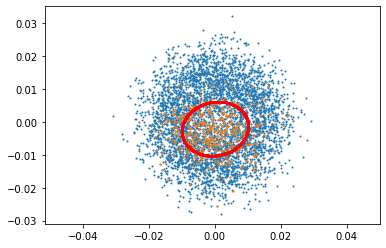

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


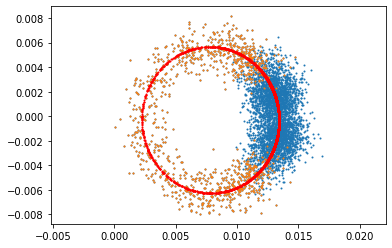

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


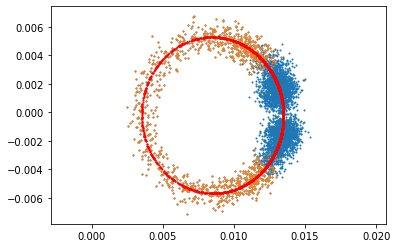

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


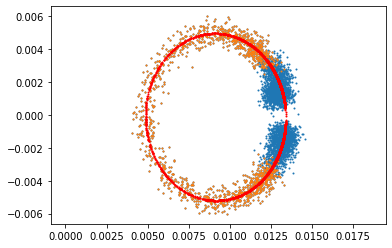

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


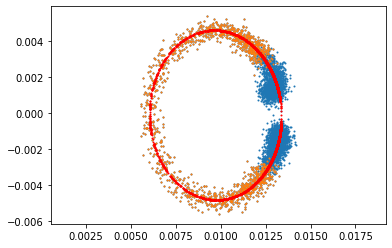

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


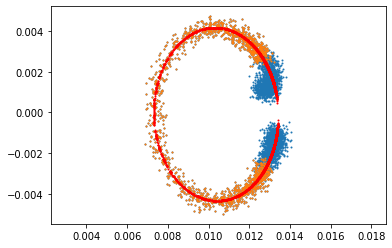

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


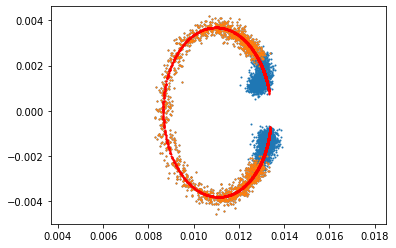

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


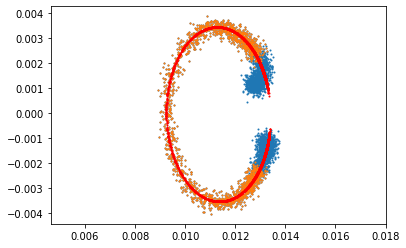

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


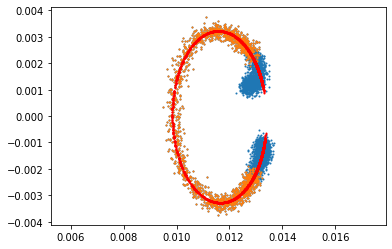

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


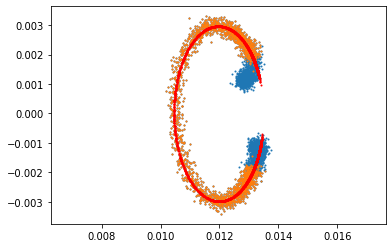

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


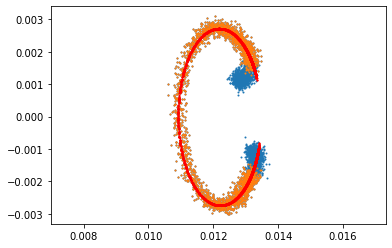

In [5]:
d.remove_background(remove_baseline=False, is_plot=True)

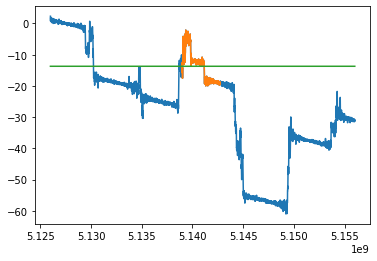

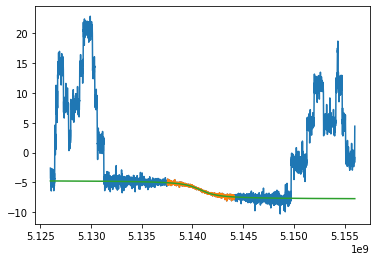

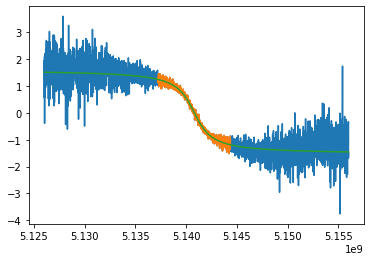

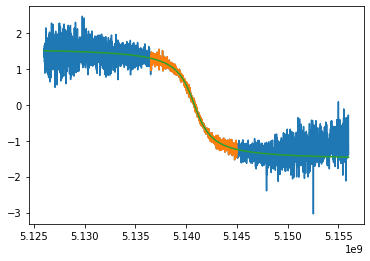

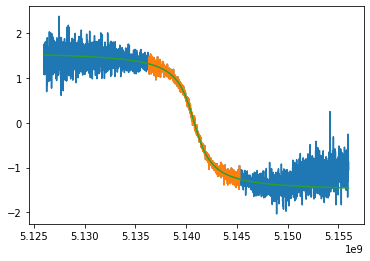

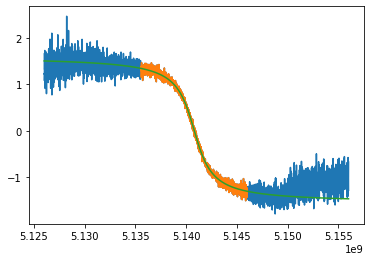

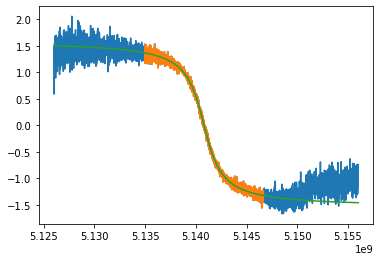

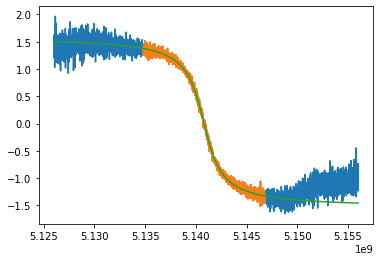

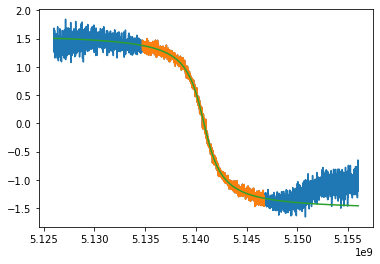

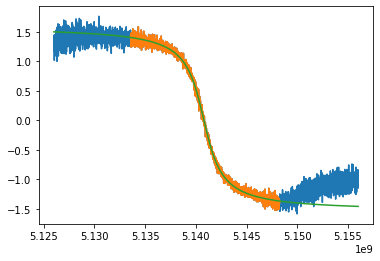

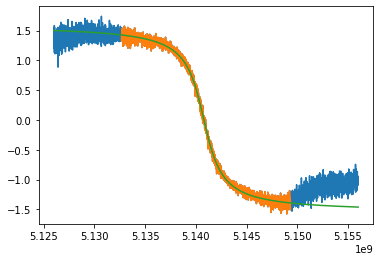

In [6]:
d.remove_mismatch(is_plot=True)

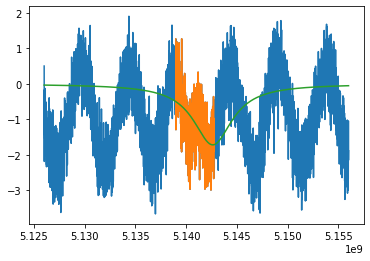

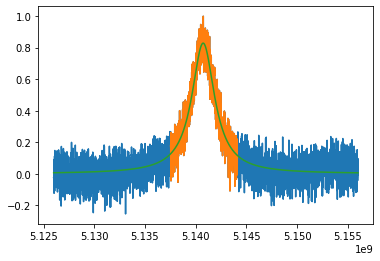

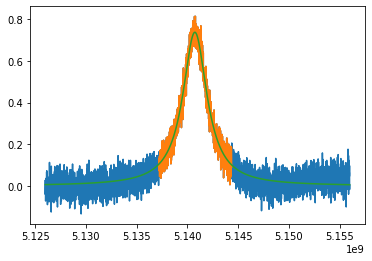

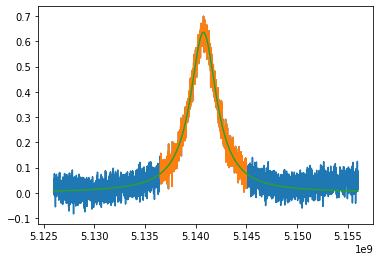

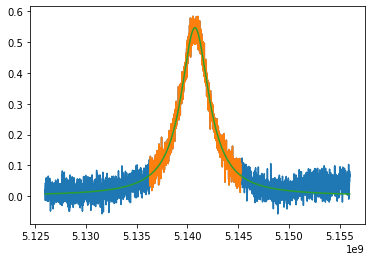

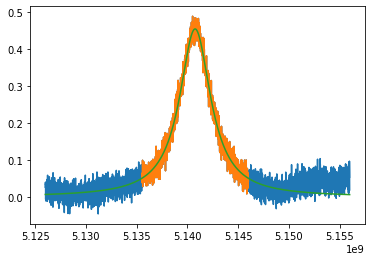

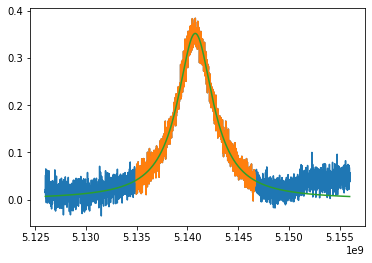

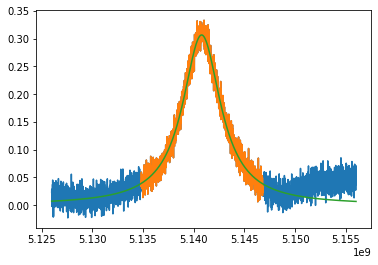

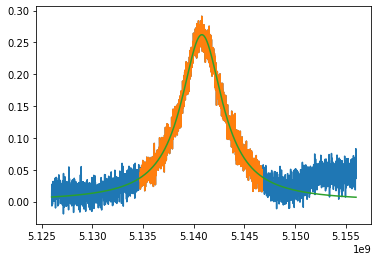

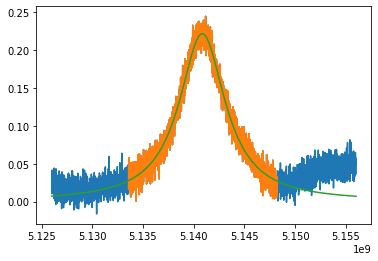

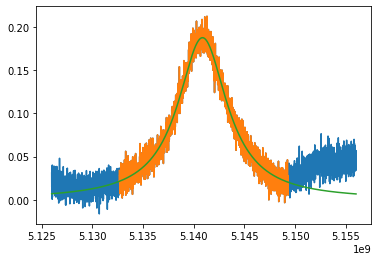

In [7]:
d.fit_lorentzian(is_plot=True)

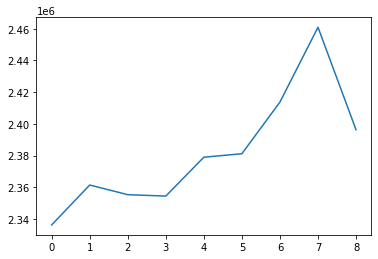

In [8]:
plt.plot(d.ig.gamma1[2:])

In [9]:
path = 'D:/LAQS/One Qubit Fit/2023.02.02/STS_FROM_POWER, 30.11.20_raw_data.pkl'
power, data, freq = unpack(file_path=path, is_number=False)
d = S21(power, data, freq)

n = len(d.power)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


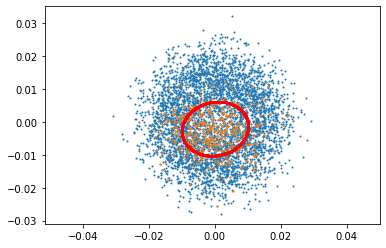

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


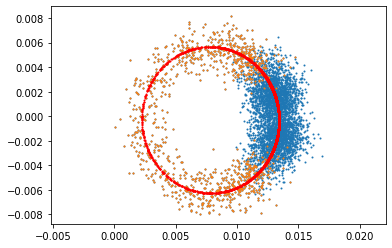

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


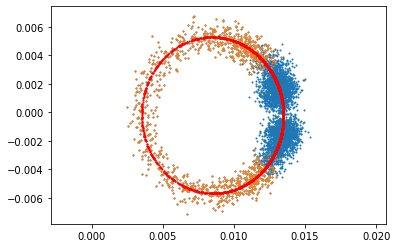

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


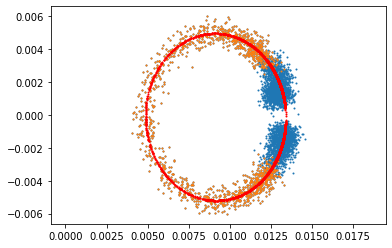

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


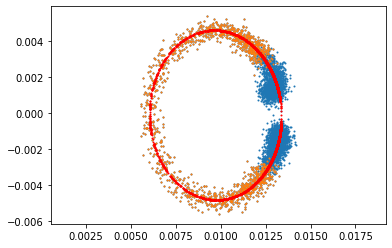

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


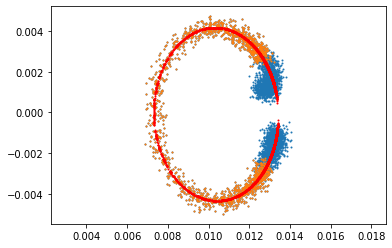

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


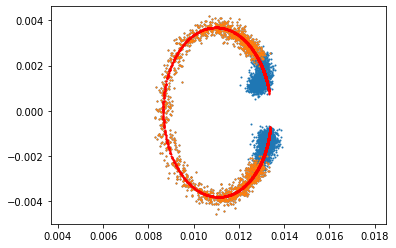

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


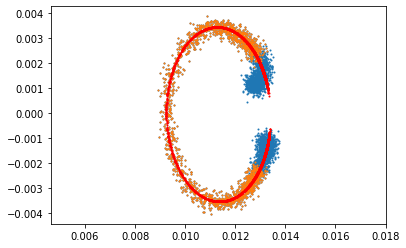

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


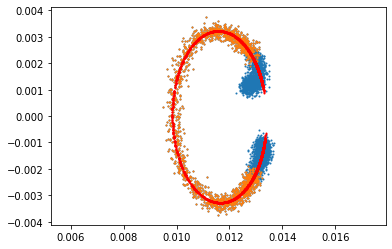

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


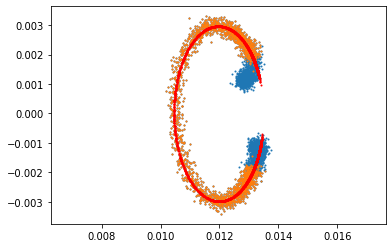

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


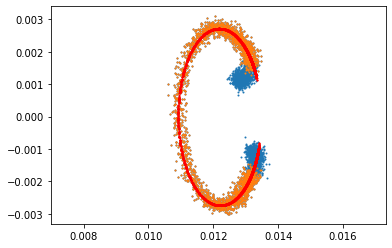

In [10]:
d.remove_background(remove_baseline=True, is_plot=True)

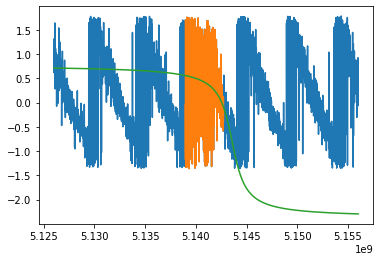

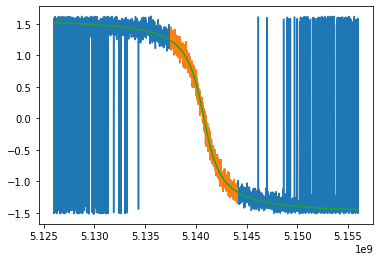

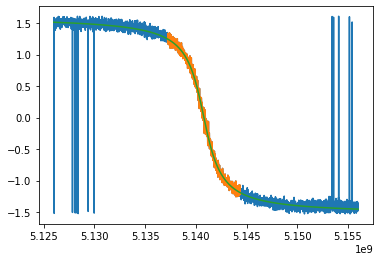

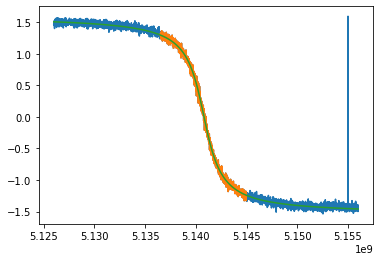

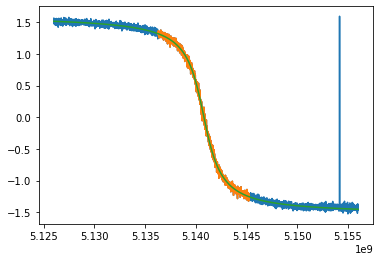

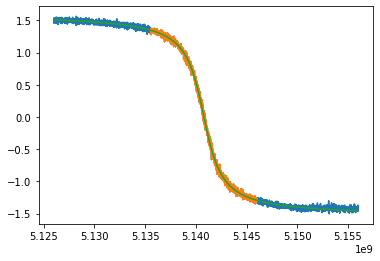

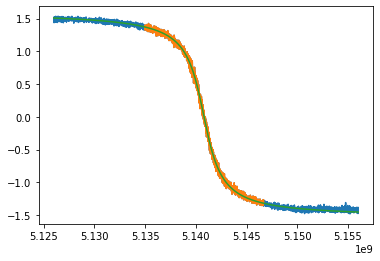

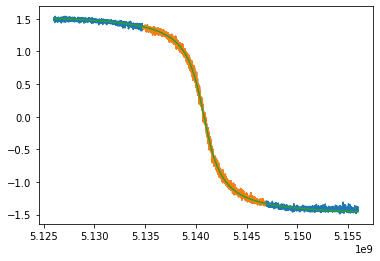

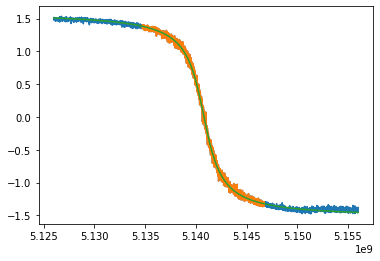

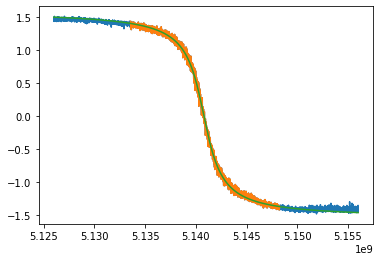

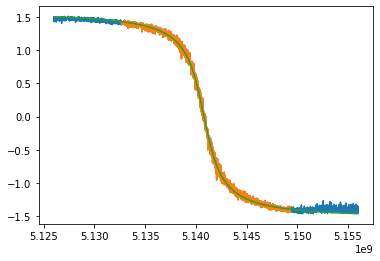

In [11]:
d.remove_mismatch(is_plot=True)

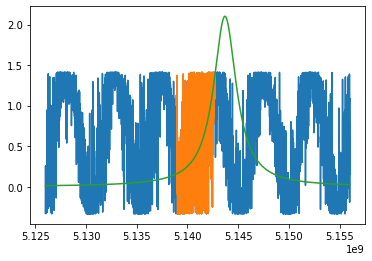

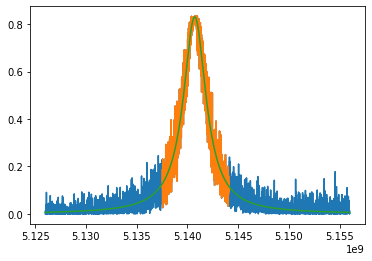

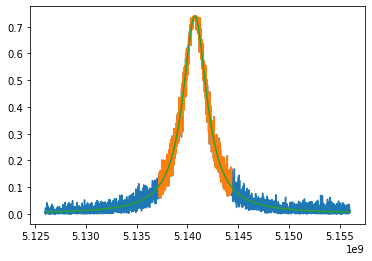

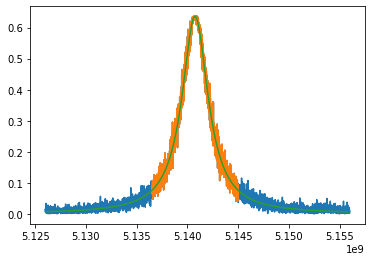

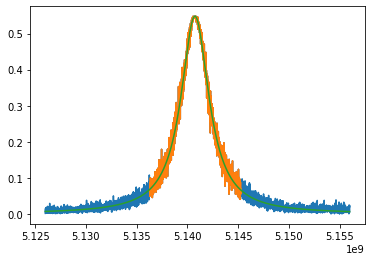

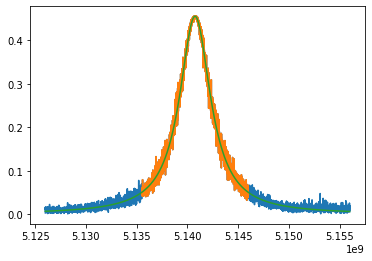

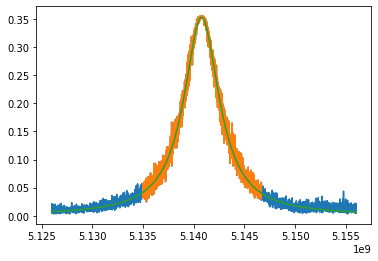

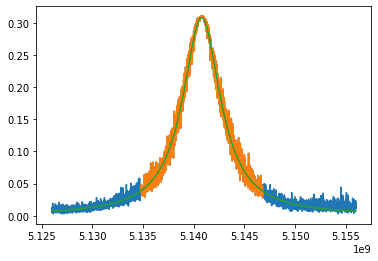

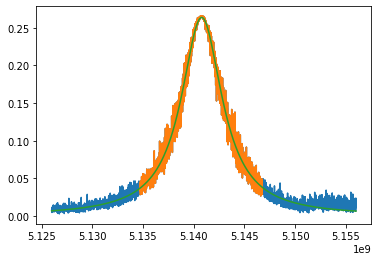

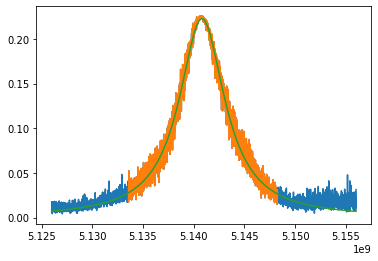

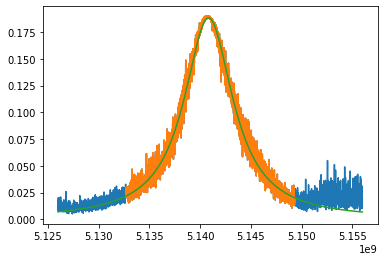

In [12]:
d.fit_lorentzian(is_plot=True)

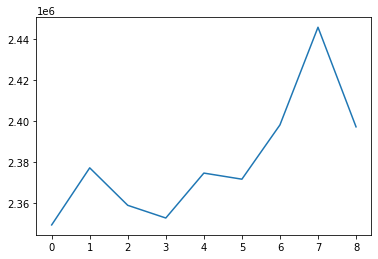

In [13]:
plt.plot(d.ig.gamma1[2:])

In [14]:
path = 'D:/LAQS/One Qubit Fit/2023.02.02/STS_FROM_POWER, 30.11.20_raw_data.pkl'
power, data, freq = unpack(file_path=path, is_number=False)
#power, data, freq = unpack(file_path='D:/LAQS/One Qubit Fit/2023.02.02/Al_III_Daria_last_try_5_8_6_3_resonators_on_power.pkl', is_number=True, freq_var=4)
# baseline = make_baseline(eps_baseline=0.0002)
d = S21(power, data, freq)
#d = S21_transmission(*generate(eps=0.000042, baseline=baseline, is_plot=True))
n = len(d.power)